## 0. Import Libraries

In [2]:
from datetime import datetime, timedelta
from glob import glob

import numpy as np
import pandas as pd
import pyproj
import rioxarray
import salem
import scipy.constants as sc
import xarray as xr
import metpy.calc as mpcalc
from shapely.geometry import mapping

import cartopy
import matplotlib.pyplot as plt
import proplot
from matplotlib.colors import BoundaryNorm, ListedColormap
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from dea_tools.spatial import xr_vectorize, xr_rasterize
from metpy.units import units

import warnings
warnings.filterwarnings('ignore')

## 1. Open GFS Data

### 1.1 GFS

#### 1.1.1 Data Options

In [3]:
general_path = 'data'
dt_type = 'gdas'

# data path
data_path = glob(fr'{general_path}/{"/boundary_input_data"}/*{dt_type}*')

In [4]:
data_path

['data//boundary_input_data/cape_gdas1.fnl0p25.2017071800.f00.grib2.nc',
 'data//boundary_input_data/cape_gdas1.fnl0p25.2017071806.f00.grib2.nc',
 'data//boundary_input_data/cape_gdas1.fnl0p25.2017071812.f00.grib2.nc',
 'data//boundary_input_data/gdas1.fnl0p25.2017071800.f00.grib2.nc',
 'data//boundary_input_data/gdas1.fnl0p25.2017071806.f00.grib2.nc',
 'data//boundary_input_data/gdas1.fnl0p25.2017071812.f00.grib2.nc',
 'data//boundary_input_data/level_gdas1.fnl0p25.2017071800.f00.grib2.nc',
 'data//boundary_input_data/level_gdas1.fnl0p25.2017071806.f00.grib2.nc',
 'data//boundary_input_data/level_gdas1.fnl0p25.2017071812.f00.grib2.nc']

In [5]:
gdas = xr.open_mfdataset(data_path)

In [6]:
gdas

<xarray.Dataset>
Dimensions:          (time: 3, level0: 3, lat: 81, lon: 121)
Coordinates:
  * time             (time) datetime64[ns] 2017-07-18 ... 2017-07-18T12:00:00
  * level0           (level0) float32 1e+03 850.0 500.0
  * lat              (lat) float32 50.0 49.75 49.5 49.25 ... 30.5 30.25 30.0
  * lon              (lon) float32 20.0 20.25 20.5 20.75 ... 49.5 49.75 50.0
Data variables:
    valid_date_time  (time) |S10 dask.array<chunksize=(1,), meta=np.ndarray>
    ref_date_time    (time) |S10 dask.array<chunksize=(1,), meta=np.ndarray>
    forecast_hour    (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    TMP_L100         (time, level0, lat, lon) float32 dask.array<chunksize=(1, 3, 81, 121), meta=np.ndarray>
    CLWMR_L100       (time, level0, lat, lon) float32 dask.array<chunksize=(1, 3, 81, 121), meta=np.ndarray>
    ABS_V_L100       (time, level0, lat, lon) float32 dask.array<chunksize=(1, 3, 81, 121), meta=np.ndarray>
    HGT_L100         (time, level0, lat, lon) float32 dask.array<chunksize=(1, 3, 81, 121), meta=np.ndarray>
    CAPE_Y108        (time, lat, lon) float32 dask.array<chunksize=(1, 81, 121), meta=np.ndarray>
    R_H_L100         (time, level0, lat, lon) float32 dask.array<chunksize=(1, 3, 81, 121), meta=np.ndarray>
Attributes:
    Creation date and time:  2022-09-12 05:04:11 -0600
    Conventions:             CF-1.5
    Creator:                 NCAR - CISL RDA (dattore)

#### 1.1.2 Calculate Specific Humidity

In [7]:
rh = gdas['R_H_L100'] * units['%']
t = gdas['TMP_L100'] * units['K']

In [8]:
# calculate dewpoint profile
d = mpcalc.dewpoint_from_relative_humidity(
    t,
    rh
)

In [9]:
# pressure values at each level
_1000 = np.ones((81,121))*1000
_850 = np.ones((81,121))*850
_500 = np.ones((81,121))*500

# concat them over level dimension
level_p = np.concatenate([_1000[np.newaxis], _850[np.newaxis], _500[np.newaxis]], axis=0)

# triple them for time dimension (3,3,81,121)
time_p = np.concatenate([level_p[np.newaxis], level_p[np.newaxis], level_p[np.newaxis]])

# assign unit
p = time_p * units['hPa']

In [10]:
# calculate specific humidity
spehum = mpcalc.specific_humidity_from_dewpoint(p, d)

In [11]:
gdas = gdas.assign(q=spehum)

In [12]:
# set units
gdas['HGT_L100'] = gdas['HGT_L100']
gdas['q'] = gdas['q'] * 1000
gdas['TMP_L100'] = gdas['TMP_L100'] - 273.15
gdas['ABS_V_L100'] = gdas['ABS_V_L100'] * 1e5

In [13]:
gdas

<xarray.Dataset>
Dimensions:          (time: 3, level0: 3, lat: 81, lon: 121)
Coordinates:
  * time             (time) datetime64[ns] 2017-07-18 ... 2017-07-18T12:00:00
  * level0           (level0) float32 1e+03 850.0 500.0
  * lat              (lat) float32 50.0 49.75 49.5 49.25 ... 30.5 30.25 30.0
  * lon              (lon) float32 20.0 20.25 20.5 20.75 ... 49.5 49.75 50.0
Data variables:
    valid_date_time  (time) |S10 dask.array<chunksize=(1,), meta=np.ndarray>
    ref_date_time    (time) |S10 dask.array<chunksize=(1,), meta=np.ndarray>
    forecast_hour    (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    TMP_L100         (time, level0, lat, lon) float32 dask.array<chunksize=(1, 3, 81, 121), meta=np.ndarray>
    CLWMR_L100       (time, level0, lat, lon) float32 dask.array<chunksize=(1, 3, 81, 121), meta=np.ndarray>
    ABS_V_L100       (time, level0, lat, lon) float32 dask.array<chunksize=(1, 3, 81, 121), meta=np.ndarray>
    HGT_L100         (time, level0, lat, lon) float32 dask.array<chunksize=(1, 3, 81, 121), meta=np.ndarray>
    CAPE_Y108        (time, lat, lon) float32 dask.array<chunksize=(1, 81, 121), meta=np.ndarray>
    R_H_L100         (time, level0, lat, lon) float32 dask.array<chunksize=(1, 3, 81, 121), meta=np.ndarray>
    q                (time, level0, lat, lon) float64 <Quantity(dask.array<mu...
Attributes:
    Creation date and time:  2022-09-12 05:04:11 -0600
    Conventions:             CF-1.5
    Creator:                 NCAR - CISL RDA (dattore)

#### 1.1.1 Open Total Precipitation

In [14]:
# A_PCP_L1_Accum_1
gdas_prec = xr.open_mfdataset(glob(fr'{general_path}/{"/boundary_input_data"}/*{"tp_g"}*'))

In [15]:
gdas_prec

<xarray.Dataset>
Dimensions:                (time: 4, ntb: 2, lat: 81, lon: 121)
Coordinates:
  * time                   (time) datetime64[ns] 2017-07-18 ... 2017-07-18T18...
  * lat                    (lat) float32 50.0 49.75 49.5 ... 30.5 30.25 30.0
  * lon                    (lon) float32 20.0 20.25 20.5 ... 49.5 49.75 50.0
Dimensions without coordinates: ntb
Data variables:
    time_bnds              (time, ntb) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    valid_date_time_range  (time, ntb) |S10 dask.array<chunksize=(1, 2), meta=np.ndarray>
    ref_date_time          (time) |S10 dask.array<chunksize=(1,), meta=np.ndarray>
    forecast_hour          (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    A_PCP_L1_Accum_1       (time, lat, lon) float32 dask.array<chunksize=(1, 81, 121), meta=np.ndarray>
Attributes:
    Creation date and time:  2022-09-13 08:17:10 -0600
    Conventions:             CF-1.5
    Creator:                 NCAR - CISL RDA (dattore)

## 2. Open ERA5 Data

### 2.1 ERA5

#### 2.1.1 Data Options

In [16]:
general_path = 'data'
dt_type = 'era5'

# data path
data_path = glob(fr'{general_path}/{"/boundary_input_data"}/*{dt_type}*')

In [17]:
era5 = xr.open_mfdataset(data_path)

#### 2.1.2 Calculate Absolute Vorticity

In [18]:
u = era5['u']*units['m/s']
v = era5['v']*units['m/s']

In [19]:
abs_vo = mpcalc.absolute_vorticity(u, v)

In [20]:
era5 = era5.assign(abs_vo=abs_vo)

In [21]:
era5

<xarray.Dataset>
Dimensions:    (longitude: 121, latitude: 81, time: 4, level: 3)
Coordinates:
  * longitude  (longitude) float32 20.0 20.25 20.5 20.75 ... 49.5 49.75 50.0
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 30.5 30.25 30.0
  * time       (time) datetime64[ns] 2017-07-18 ... 2017-07-18T18:00:00
  * level      (level) int32 500 850 1000
Data variables:
    cape       (time, latitude, longitude) float32 dask.array<chunksize=(4, 81, 121), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(4, 81, 121), meta=np.ndarray>
    z          (time, level, latitude, longitude) float32 dask.array<chunksize=(4, 3, 81, 121), meta=np.ndarray>
    q          (time, level, latitude, longitude) float32 dask.array<chunksize=(4, 3, 81, 121), meta=np.ndarray>
    t          (time, level, latitude, longitude) float32 dask.array<chunksize=(4, 3, 81, 121), meta=np.ndarray>
    u          (time, level, latitude, longitude) float32 dask.array<chunksize=(4, 3, 81, 121), meta=np.ndarray>
    v          (time, level, latitude, longitude) float32 dask.array<chunksize=(4, 3, 81, 121), meta=np.ndarray>
    vo         (time, level, latitude, longitude) float32 dask.array<chunksize=(4, 3, 81, 121), meta=np.ndarray>
    abs_vo     (time, level, latitude, longitude) float64 <Quantity([[[[ 8.35...
Attributes:
    Conventions:  CF-1.6
    history:      2022-09-12 14:02:53 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

#### 2.1.3 Open Total Precipitation

In [22]:
# tp
era5_prec = xr.open_mfdataset(glob(fr'{general_path}/{"/boundary_input_data"}/*{"tp_ad"}*')).resample(time='6H',
                                                                                                      label='right').sum().sel(time='2017-07-18')

In [23]:
# set units
era5['z'] = era5['z'] / sc.g
era5['q'] = era5['q'] * 1000
era5['t'] = era5['t'] - 273.15
era5['abs_vo'] = era5['abs_vo'] * 1e5
era5_prec = era5_prec * 1000

## 3. Define Common Lower and Upper Limits For Plots

### 3.1 Temperature

In [24]:
time_ = 3
t_limits = {
    1000:{
        'upper':np.max([
            gdas['TMP_L100'].isel(time=slice(0,time_)).sel(level0=1000).max().compute(),
            era5['t'].isel(time=slice(0,time_)).sel(level=1000).max().compute()
        ]),
        'lower':np.min([
            gdas['TMP_L100'].isel(time=slice(0,time_)).sel(level0=1000).min().compute(),
            era5['t'].isel(time=slice(0,time_)).sel(level=1000).min().compute()
        ])
    },
    
    850:{
        'upper':np.max([
            gdas['TMP_L100'].isel(time=slice(0,time_)).sel(level0=850).max().compute(),
            era5['t'].isel(time=slice(0,time_)).sel(level=850).max().compute()
        ]),
        'lower':np.min([
            gdas['TMP_L100'].isel(time=slice(0,time_)).sel(level0=850).min().compute(),
            era5['t'].isel(time=slice(0,time_)).sel(level=850).min().compute()
        ])
    },
    
    500:{
        'upper':np.max([
            gdas['TMP_L100'].isel(time=slice(0,time_)).sel(level0=500).max().compute(),
            era5['t'].isel(time=slice(0,time_)).sel(level=500).max().compute()
        ]),
        'lower':np.min([
            gdas['TMP_L100'].isel(time=slice(0,time_)).sel(level0=500).min().compute(),
            era5['t'].isel(time=slice(0,time_)).sel(level=500).min().compute()
        ])
    }
}

### 3.2 Absolute Vorticity

In [25]:
vo_limits = {
    1000:{
        'upper':np.max([
            gdas['ABS_V_L100'].isel(time=slice(0,time_)).sel(level0=1000).max().compute(),
            era5['abs_vo'].isel(time=slice(0,time_)).sel(level=1000).max().compute()
        ]),
        'lower':np.min([
            gdas['ABS_V_L100'].isel(time=slice(0,time_)).sel(level0=1000).min().compute(),
            era5['abs_vo'].isel(time=slice(0,time_)).sel(level=1000).min().compute()
        ])
    },
    
    850:{
        'upper':np.max([
            gdas['ABS_V_L100'].isel(time=slice(0,time_)).sel(level0=850).max().compute(),
            era5['abs_vo'].isel(time=slice(0,time_)).sel(level=850).max().compute()
        ]),
        'lower':np.min([
            gdas['ABS_V_L100'].isel(time=slice(0,time_)).sel(level0=850).min().compute(),
            era5['abs_vo'].isel(time=slice(0,time_)).sel(level=850).min().compute()
        ])
    },
    
    500:{
        'upper':np.max([
            gdas['ABS_V_L100'].isel(time=slice(0,time_)).sel(level0=500).max().compute(),
            era5['abs_vo'].isel(time=slice(0,time_)).sel(level=500).max().compute()
        ]),
        'lower':np.min([
            gdas['ABS_V_L100'].isel(time=slice(0,time_)).sel(level0=500).min().compute(),
            era5['abs_vo'].isel(time=slice(0,time_)).sel(level=500).min().compute()
        ])
    }
}

### 3.3 Specific Humidity

In [26]:
q_limits = {
    1000:{
        'upper':np.max([
            gdas['q'].isel(time=slice(0,time_)).sel(level0=1000).max().compute(),
            era5['q'].isel(time=slice(0,time_)).sel(level=1000).max().compute()
        ]),
        'lower':np.min([
            gdas['q'].isel(time=slice(0,time_)).sel(level0=1000).min().compute(),
            era5['q'].isel(time=slice(0,time_)).sel(level=1000).min().compute()
        ])
    },
    
    850:{
        'upper':np.max([
            gdas['q'].isel(time=slice(0,time_)).sel(level0=850).max().compute(),
            era5['q'].isel(time=slice(0,time_)).sel(level=850).max().compute()
        ]),
        'lower':np.min([
            gdas['q'].isel(time=slice(0,time_)).sel(level0=850).min().compute(),
            era5['q'].isel(time=slice(0,time_)).sel(level=850).min().compute()
        ])
    },
    
    500:{
        'upper':np.max([
            gdas['q'].isel(time=slice(0,time_)).sel(level0=500).max().compute(),
            era5['q'].isel(time=slice(0,time_)).sel(level=500).max().compute()
        ]),
        'lower':np.min([
            gdas['q'].isel(time=slice(0,time_)).sel(level0=500).min().compute(),
            era5['q'].isel(time=slice(0,time_)).sel(level=500).min().compute()
        ])
    }
}

### 3.4 CAPE

In [27]:
cape_limits = {
    'sfc':{
        'upper':np.max([
            gdas['CAPE_Y108'].isel(time=slice(0,time_)).max().compute(),
            era5['cape'].isel(time=slice(0,time_)).max().compute()
        ]),
        'lower':np.min([
            gdas['CAPE_Y108'].isel(time=slice(0,time_)).min().compute(),
            era5['cape'].isel(time=slice(0,time_)).min().compute()
        ])
    }
}

### 3.5 G. Height

In [28]:
z_limits = {
    1000:{
        'upper':np.max([
            gdas['HGT_L100'].isel(time=slice(0,time_)).sel(level0=1000).max().compute(),
            era5['z'].isel(time=slice(0,time_)).sel(level=1000).max().compute()
        ]),
        'lower':np.min([
            gdas['HGT_L100'].isel(time=slice(0,time_)).sel(level0=1000).min().compute(),
            era5['z'].isel(time=slice(0,time_)).sel(level=1000).min().compute()
        ])
    },
    
    850:{
        'upper':np.max([
            gdas['HGT_L100'].isel(time=slice(0,time_)).sel(level0=850).max().compute(),
            era5['z'].isel(time=slice(0,time_)).sel(level=850).max().compute()
        ]),
        'lower':np.min([
            gdas['HGT_L100'].isel(time=slice(0,time_)).sel(level0=850).min().compute(),
            era5['z'].isel(time=slice(0,time_)).sel(level=850).min().compute()
        ])
    },
    
    500:{
        'upper':np.max([
            gdas['HGT_L100'].isel(time=slice(0,time_)).sel(level0=500).max().compute(),
            era5['z'].isel(time=slice(0,time_)).sel(level=500).max().compute()
        ]),
        'lower':np.min([
            gdas['HGT_L100'].isel(time=slice(0,time_)).sel(level0=500).min().compute(),
            era5['z'].isel(time=slice(0,time_)).sel(level=500).min().compute()
        ])
    }
}

### 3.6 Total Precipitation

In [29]:
tp_limits = {
    'sfc':{
        'upper':np.max([
            gdas_prec['A_PCP_L1_Accum_1'].isel(time=slice(0,time_)).max().compute(),
            era5_prec['tp'].isel(time=slice(0,time_)).max().compute()
        ]),
        'lower':np.min([
            gdas_prec['A_PCP_L1_Accum_1'].isel(time=slice(0,time_)).min().compute(),
            era5_prec['tp'].isel(time=slice(0,time_)).min().compute()
        ])
    }
    
}

In [30]:
t_limits

{1000: {'upper': 49.75, 'lower': 13.950012},
 850: {'upper': 36.55002, 'lower': 7.950012},
 500: {'upper': -1.4598694, 'lower': -16.25}}

In [31]:
z_limits

{1000: {'upper': 199.09918, 'lower': -59.796158},
 850: {'upper': 1572.251, 'lower': 1435.0829},
 500: {'upper': 5940.705, 'lower': 5721.8555}}

In [32]:
vo_limits

{1000: {'upper': 55.79999923706055, 'lower': -21.600000381469727},
 850: {'upper': 44.79999923706055, 'lower': -24.100000381469727},
 500: {'upper': 35.79999923706055, 'lower': -12.399999618530273}}

In [33]:
q_limits

{1000: {'upper': 24.757511138916016, 'lower': 1.7080770589346612},
 850: {'upper': 16.005367256955644, 'lower': 0.06932541180063419},
 500: {'upper': 4.93595787913327, 'lower': 0.002840797143957569}}

In [34]:
cape_limits

{'sfc': {'upper': 3993.75, 'lower': -0.00012207031}}

In [35]:
tp_limits

{'sfc': {'upper': 53.43973, 'lower': 0.0}}

## 4. Visualization - ERA5

### 4.1 Open Land Use Datasets

In [36]:
luse_var = 'LU_INDEX'
urban_luse_border = xr.open_dataset(fr'{general_path}/wrfout_d03_LU_INDEX_urban.nc')[luse_var]
urban_luse_border = urban_luse_border.where(urban_luse_border==1, 0).isel(west_east = slice(35, 162),
                                                                               south_north = slice(57, 157))

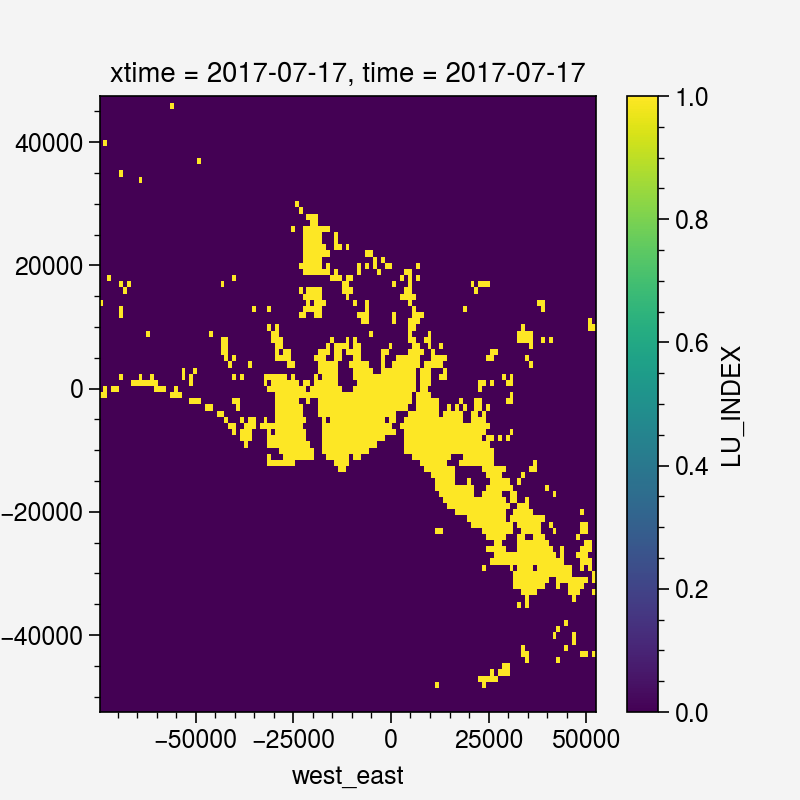

In [37]:
urban_luse_border.plot()

### 4.1 Parameters

In [38]:
# Parameters to change (plot) -------------------
# projection
proj = '+proj=lcc +lat_0=41.0720100402832 +lon_0=28.9729995727539 +lat_1=41.0719985961914 +lat_2=41.0719985961914 +x_0=0 +y_0=0 +R=6370000 +units=m +no_defs'
gdas = gdas.rio.write_crs(proj)
proj = gdas.rio.crs.to_dict()
globe = cartopy.crs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
lcc = cartopy.crs.LambertConformal(globe=globe, # important!
                            central_longitude=proj['lon_0'], 
                            central_latitude=proj['lat_0'],
                            standard_parallels=(proj['lat_1'], proj['lat_2']),
                            )

# fig features
fig_array = [[1,2,3],
             [4,5,6],
             [7,8,9],
             [10,11,12],
             [13,14,15],
             [16,17,18]
            ]
graphic_no = 18
cmap_temp = 'seismic'
level = 1000

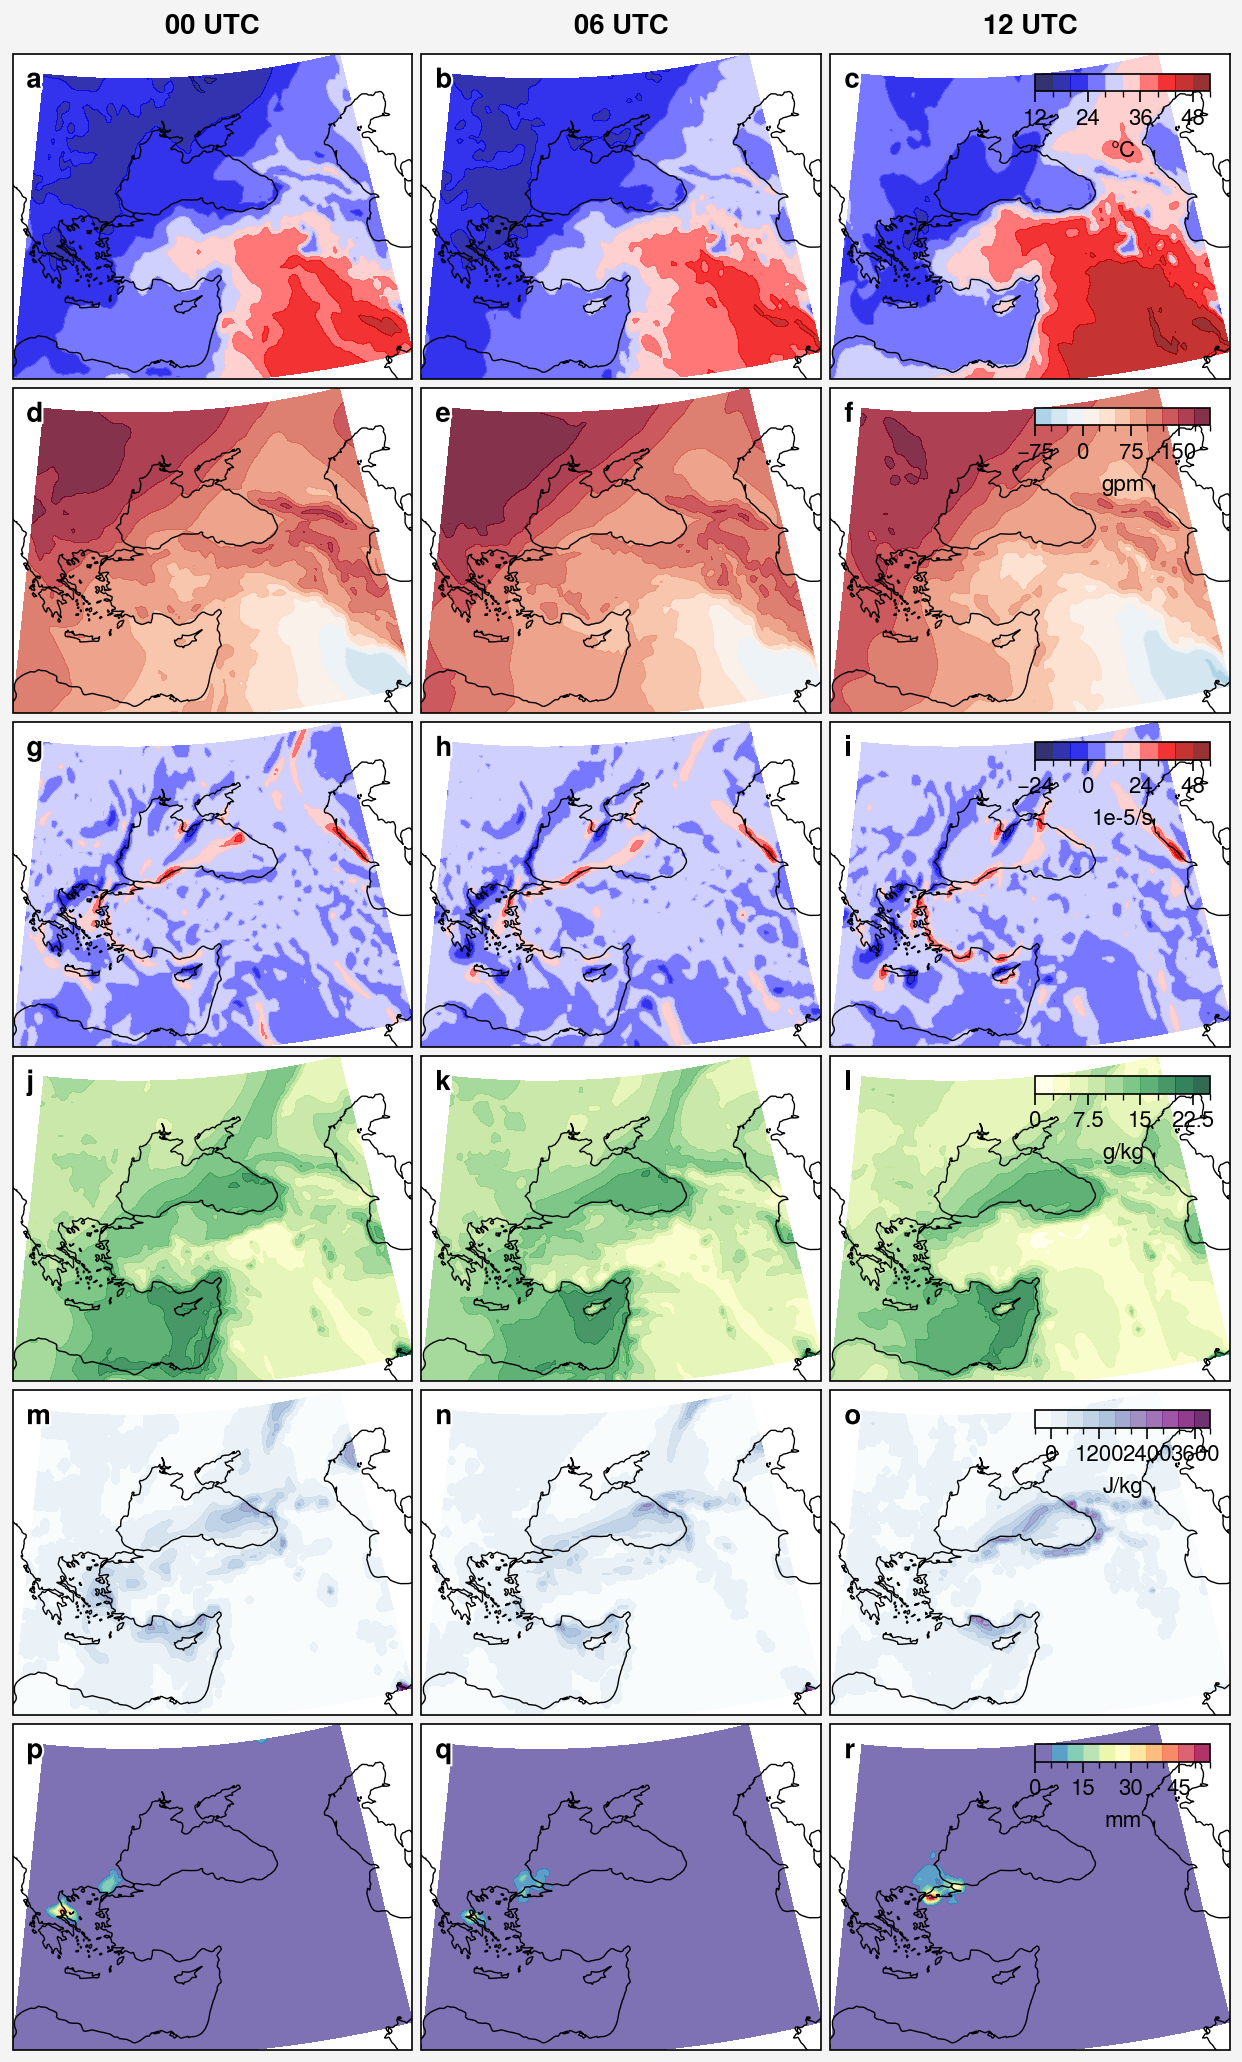

In [107]:
# Create Figure -------------------------
fig, axs = proplot.subplots(fig_array, 
                            aspect=4,
                            axwidth=2,
                            proj=lcc,
                            hratios=tuple(np.ones(len(fig_array), dtype=int)),
                            includepanels=True,
                            hspace=0.36,
                            wspace=0.36,
                            sharey=0)

# format whole figure
axs.format(abcloc='ul',
           abc=True,)

# istanbul limits
axs.format(lonlim=(20, 50),
           latlim=(30, 50),
           labels=False, 
           longrid=False, 
           latgrid = False)

axs.format(collabels=['00 UTC', '06 UTC', '12 UTC'],
           )

#proplot.rc['leftlabel.rotation'] = 'vertical'
proplot.rc.update({'leftlabel.rotation':'vertical'})

# add shapefiles
axs.add_feature(cartopy.feature.LAND.with_scale('50m'),
               zorder=1, linewidths=0.5,
               edgecolor='black', facecolor='none') 
    
    
dt_border = urban_luse_border

# era5 temperature
for i in range(3):
    dt_ = (era5['t'].isel(time=i).sel(level=level))
    mesh_temp = axs[i].contourf(era5['longitude'], 
                                era5['latitude'],
                                dt_, 
                                cmap = cmap_temp,
                                vmin = t_limits[level]['upper'],
                                vmax = t_limits[level]['lower'],
                                zorder = 0.2,
                                alpha=0.8)
    
# era5 geo height
for i in range(3):
    dt_ = (era5['z'].isel(time=i).sel(level=level))
    mesh_height = axs[i+3].contourf(era5['longitude'], 
                                era5['latitude'],
                                dt_, 
                                cmap = 'RdBu_r',
                                vmin = z_limits[level]['upper'],
                                vmax = z_limits[level]['lower'],
                                zorder = 0.2,
                                alpha=0.8)
    
# era5 abs vort
for i in range(3):
    dt_ = (era5['abs_vo'].isel(time=i).sel(level=level))
    mesh_vort = axs[i+6].contourf(era5['longitude'], 
                                era5['latitude'],
                                dt_, 
                                cmap = cmap_temp,
                                vmin = vo_limits[level]['upper'],
                                vmax = vo_limits[level]['lower'],
                                zorder = 0.2,
                                alpha=0.8)
    
# era5 spe hum
for i in range(3):
    dt_ = (era5['q'].isel(time=i).sel(level=level))
    mesh_mix = axs[i+9].contourf(era5['longitude'], 
                                era5['latitude'],
                                dt_, 
                                cmap = 'YlGn',
                                vmin = q_limits[level]['upper'],
                                vmax = q_limits[level]['lower'],
                                zorder = 0.2,
                                alpha=0.8)
    
# era5 cape
for i in range(3):
    dt_ = (era5['cape'].isel(time=i))
    mesh_cape = axs[i+12].contourf(era5['longitude'], 
                                era5['latitude'],
                                dt_, 
                                cmap = 'BuPu',
                                vmin = cape_limits['sfc']['upper'],
                                vmax = cape_limits['sfc']['lower'],
                                zorder = 0.2,
                                alpha=0.8)
    
# era5 tp
for i in range(3):
    dt_ = (era5_prec['tp'].isel(time=i))
    mesh_tp = axs[i+15].contourf(era5['longitude'], 
                                era5['latitude'],
                                dt_, 
                                cmap = 'Spectral_r',
                                vmin = tp_limits['sfc']['upper'],
                                vmax = tp_limits['sfc']['lower'],
                                zorder = 0.2,
                                alpha=0.8)

# colorbars
axs[2].colorbar(mesh_temp,
                 label='°C',
                 loc='ur', length=7,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.7,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=False,
                 pad = 0.8
                )

axs[5].colorbar(mesh_height,
                 label='gpm',
                 loc='ur', length=7,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.7,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=False,
                 pad = 0.8
                )

axs[8].colorbar(mesh_vort,
                 label='1e-5/s',
                 loc='ur', length=7,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.7,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=False,
                 pad = 0.8
                )

axs[11].colorbar(mesh_mix,
                 label='g/kg',
                 loc='ur', length=7,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.7,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=False,
                 pad = 0.8
                )
                                        
axs[14].colorbar(mesh_cape,
                 label='J/kg',
                 loc='ur', length=7,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.7,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=False,
                 pad = 0.8
                )

axs[17].colorbar(mesh_tp,
                 label='mm',
                 loc='ur', length=7,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.7,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=False,
                 pad = 0.8
                )

#save figure
plt.savefig(fr'pictures/combined_boundary_data_era5_{level}.jpeg',
            bbox_inches='tight', optimize=True,
            progressive=True, dpi=1000)

## 5. Visualization - GFS

### 5.1 Parameters

In [110]:
level = 1000

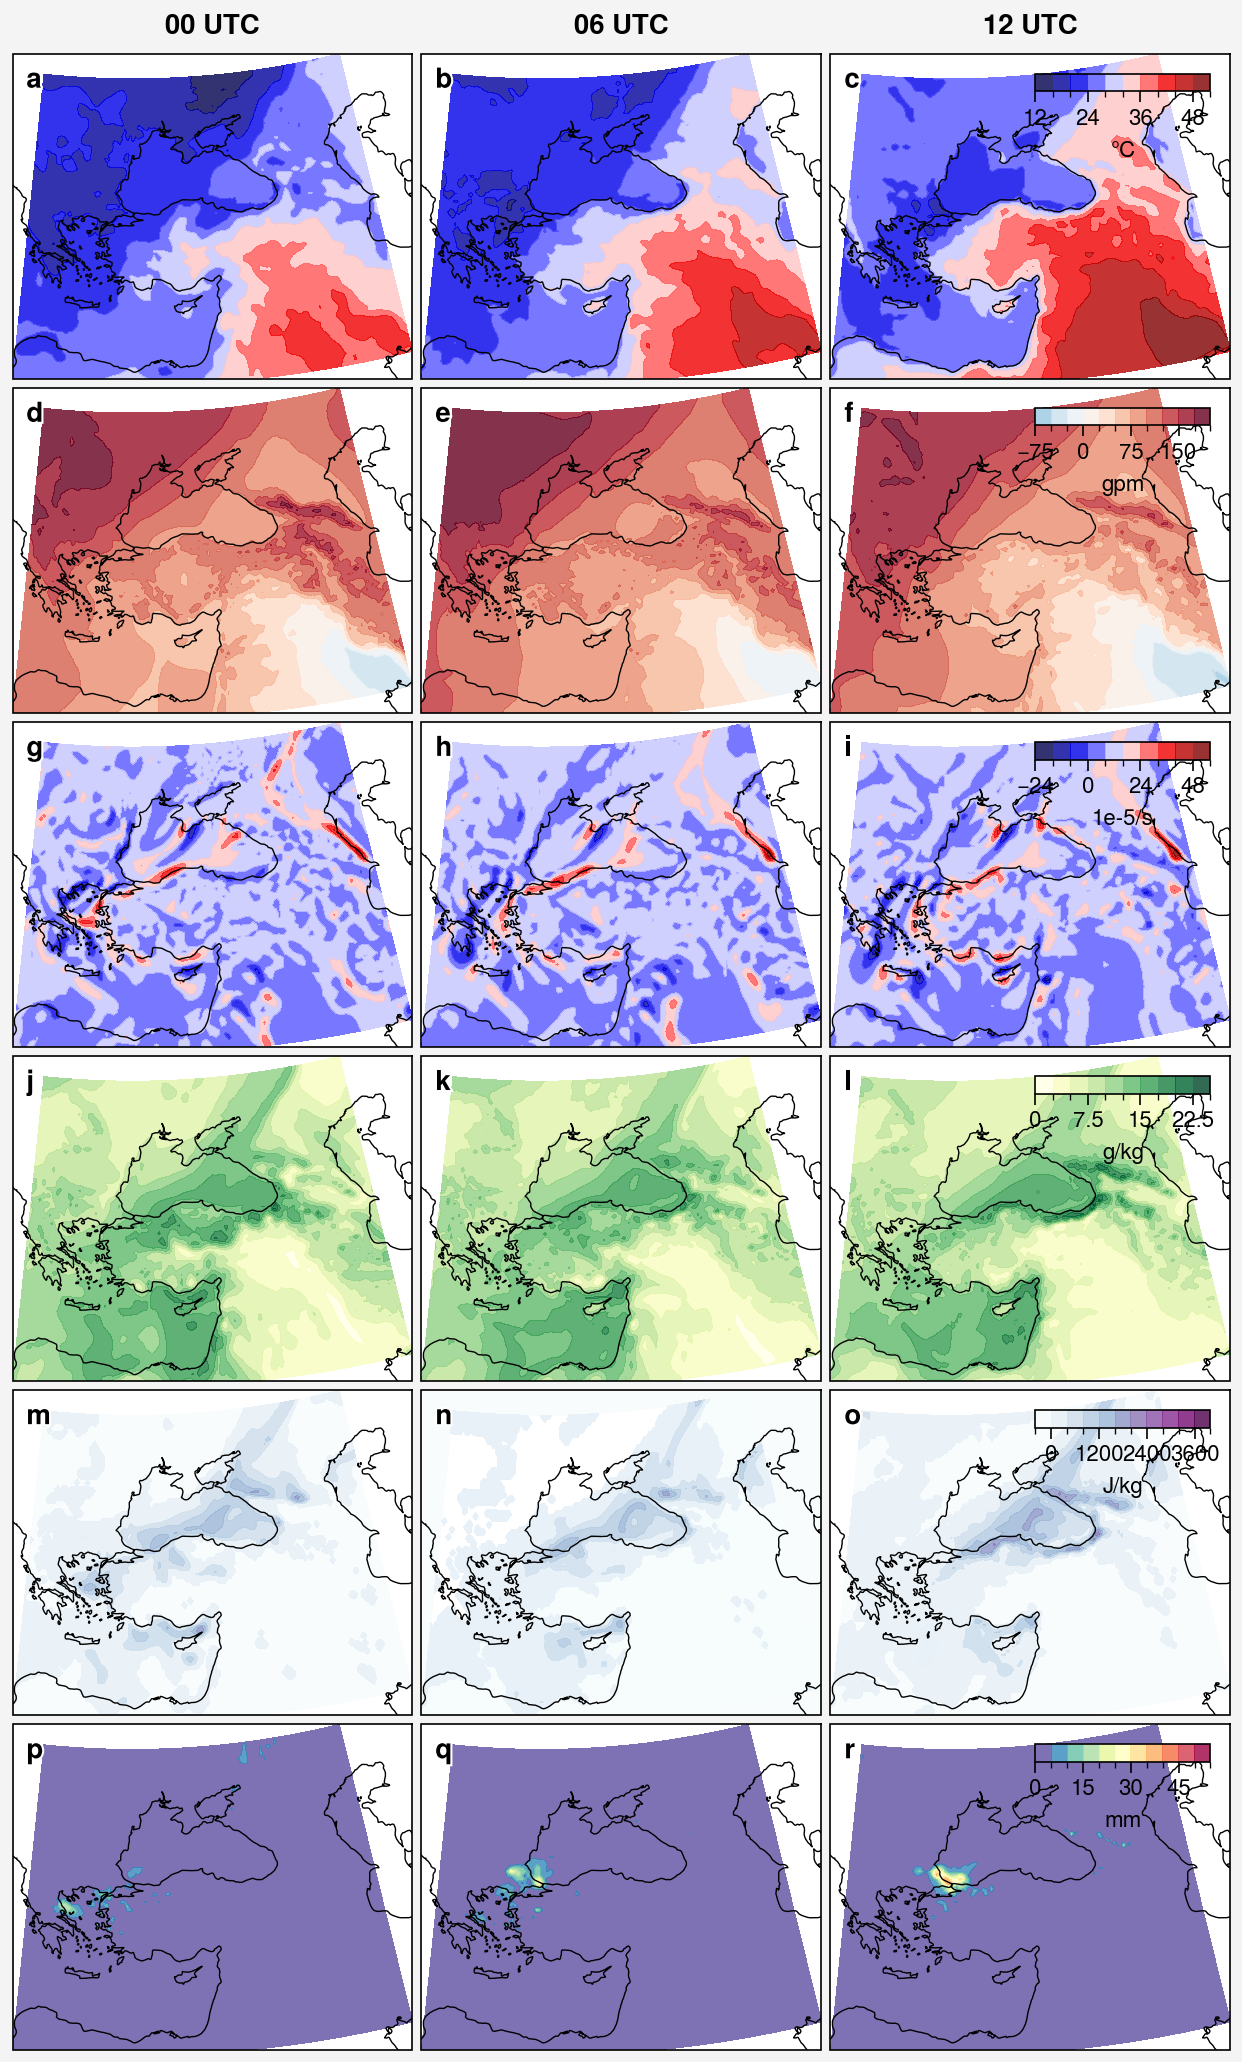

In [111]:
# Create Figure -------------------------
fig, axs = proplot.subplots(fig_array, 
                            aspect=4,
                            axwidth=2,
                            proj=lcc,
                            hratios=tuple(np.ones(len(fig_array), dtype=int)),
                            includepanels=True,
                            hspace=0.36,
                            wspace=0.36,
                            sharey=0)

# format whole figure
axs.format(abcloc='ul',
           abc=True,)

# istanbul limits
axs.format(lonlim=(20, 50),
           latlim=(30, 50),
           labels=False, 
           longrid=False, 
           latgrid = False)

axs.format(collabels=['00 UTC', '06 UTC', '12 UTC'],
           )

#proplot.rc['leftlabel.rotation'] = 'vertical'
proplot.rc.update({'leftlabel.rotation':'vertical'})

# add shapefiles
axs.add_feature(cartopy.feature.LAND.with_scale('50m'),
               zorder=1, linewidths=0.5,
               edgecolor='black', facecolor='none') 
    
    
dt_border = urban_luse_border

# gfs temperature
for i in range(3):
    dt_ = (gdas['TMP_L100'].isel(time=i).sel(level0=level))
    mesh_temp = axs[i].contourf(gdas['lon'], 
                                gdas['lat'],
                                dt_, 
                                cmap = cmap_temp,
                                vmin = t_limits[level]['upper'],
                                vmax = t_limits[level]['lower'],
                                zorder = 0.2,
                                alpha=0.8)
    
# gfs geo height
for i in range(3):
    dt_ = (gdas['HGT_L100'].isel(time=i).sel(level0=level))
    mesh_height = axs[i+3].contourf(gdas['lon'], 
                                gdas['lat'],
                                dt_, 
                                cmap = 'RdBu_r',
                                vmin = z_limits[level]['upper'],
                                vmax = z_limits[level]['lower'],
                                zorder = 0.2,
                                alpha=0.8)
    
# gfs abs vort
for i in range(3):
    dt_ = (gdas['ABS_V_L100'].isel(time=i).sel(level0=level))
    mesh_vort = axs[i+6].contourf(gdas['lon'], 
                                gdas['lat'],
                                dt_, 
                                cmap = cmap_temp,
                                vmin = vo_limits[level]['upper'],
                                vmax = vo_limits[level]['lower'],
                                zorder = 0.2,
                                alpha=0.8)
    
# gfs specific humidity
for i in range(3):
    dt_ = (gdas['q'].isel(time=i).sel(level0=level))
    mesh_mix = axs[i+9].contourf(gdas['lon'], 
                                gdas['lat'],
                                dt_, 
                                cmap = 'YlGn',
                                vmin = q_limits[level]['upper'],
                                vmax = q_limits[level]['lower'],
                                zorder = 0.2,
                                alpha=0.8)
    
# gfs cape
for i in range(3):
    dt_ = (gdas['CAPE_Y108'].isel(time=i))
    mesh_cape = axs[i+12].contourf(gdas['lon'], 
                                gdas['lat'],
                                dt_, 
                                cmap = 'BuPu',
                                vmin = cape_limits['sfc']['upper'],
                                vmax = cape_limits['sfc']['lower'],
                                zorder = 0.2,
                                alpha=0.8)
    
# gfs tp
for i in range(3):
    dt_ = (gdas_prec['A_PCP_L1_Accum_1'].isel(time=i))
    mesh_tp = axs[i+15].contourf(gdas_prec['lon'], 
                                gdas_prec['lat'],
                                dt_, 
                                cmap = 'Spectral_r',
                                vmin = tp_limits['sfc']['upper'],
                                vmax = tp_limits['sfc']['lower'],
                                zorder = 0.2,
                                alpha=0.8)

# colorbars
axs[2].colorbar(mesh_temp,
                 label='°C',
                 loc='ur', length=7,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.7,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=False,
                 pad = 0.8
                )

axs[5].colorbar(mesh_height,
                 label='gpm',
                 loc='ur', length=7,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.7,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=False,
                 pad = 0.8
                )

axs[8].colorbar(mesh_vort,
                 label='1e-5/s',
                 loc='ur', length=7,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.7,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=False,
                 pad = 0.8
                )

axs[11].colorbar(mesh_mix,
                 label='g/kg',
                 loc='ur', length=7,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.7,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=False,
                 pad = 0.8
                )
                                        
axs[14].colorbar(mesh_cape,
                 label='J/kg',
                 loc='ur', length=7,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.7,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=False,
                 pad = 0.8
                )

axs[17].colorbar(mesh_tp,
                 label='mm',
                 loc='ur', length=7,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.7,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=False,
                 pad = 0.8
                )

#save figure
plt.savefig(fr'pictures/combined_boundary_data_gdas_{level}.jpeg',
            bbox_inches='tight', optimize=True,
            progressive=True, dpi=1000)

## 6. Visualization - Difference

### 6.1 Parameters

In [71]:
level = 1000
cmap_diff = 'seismic'

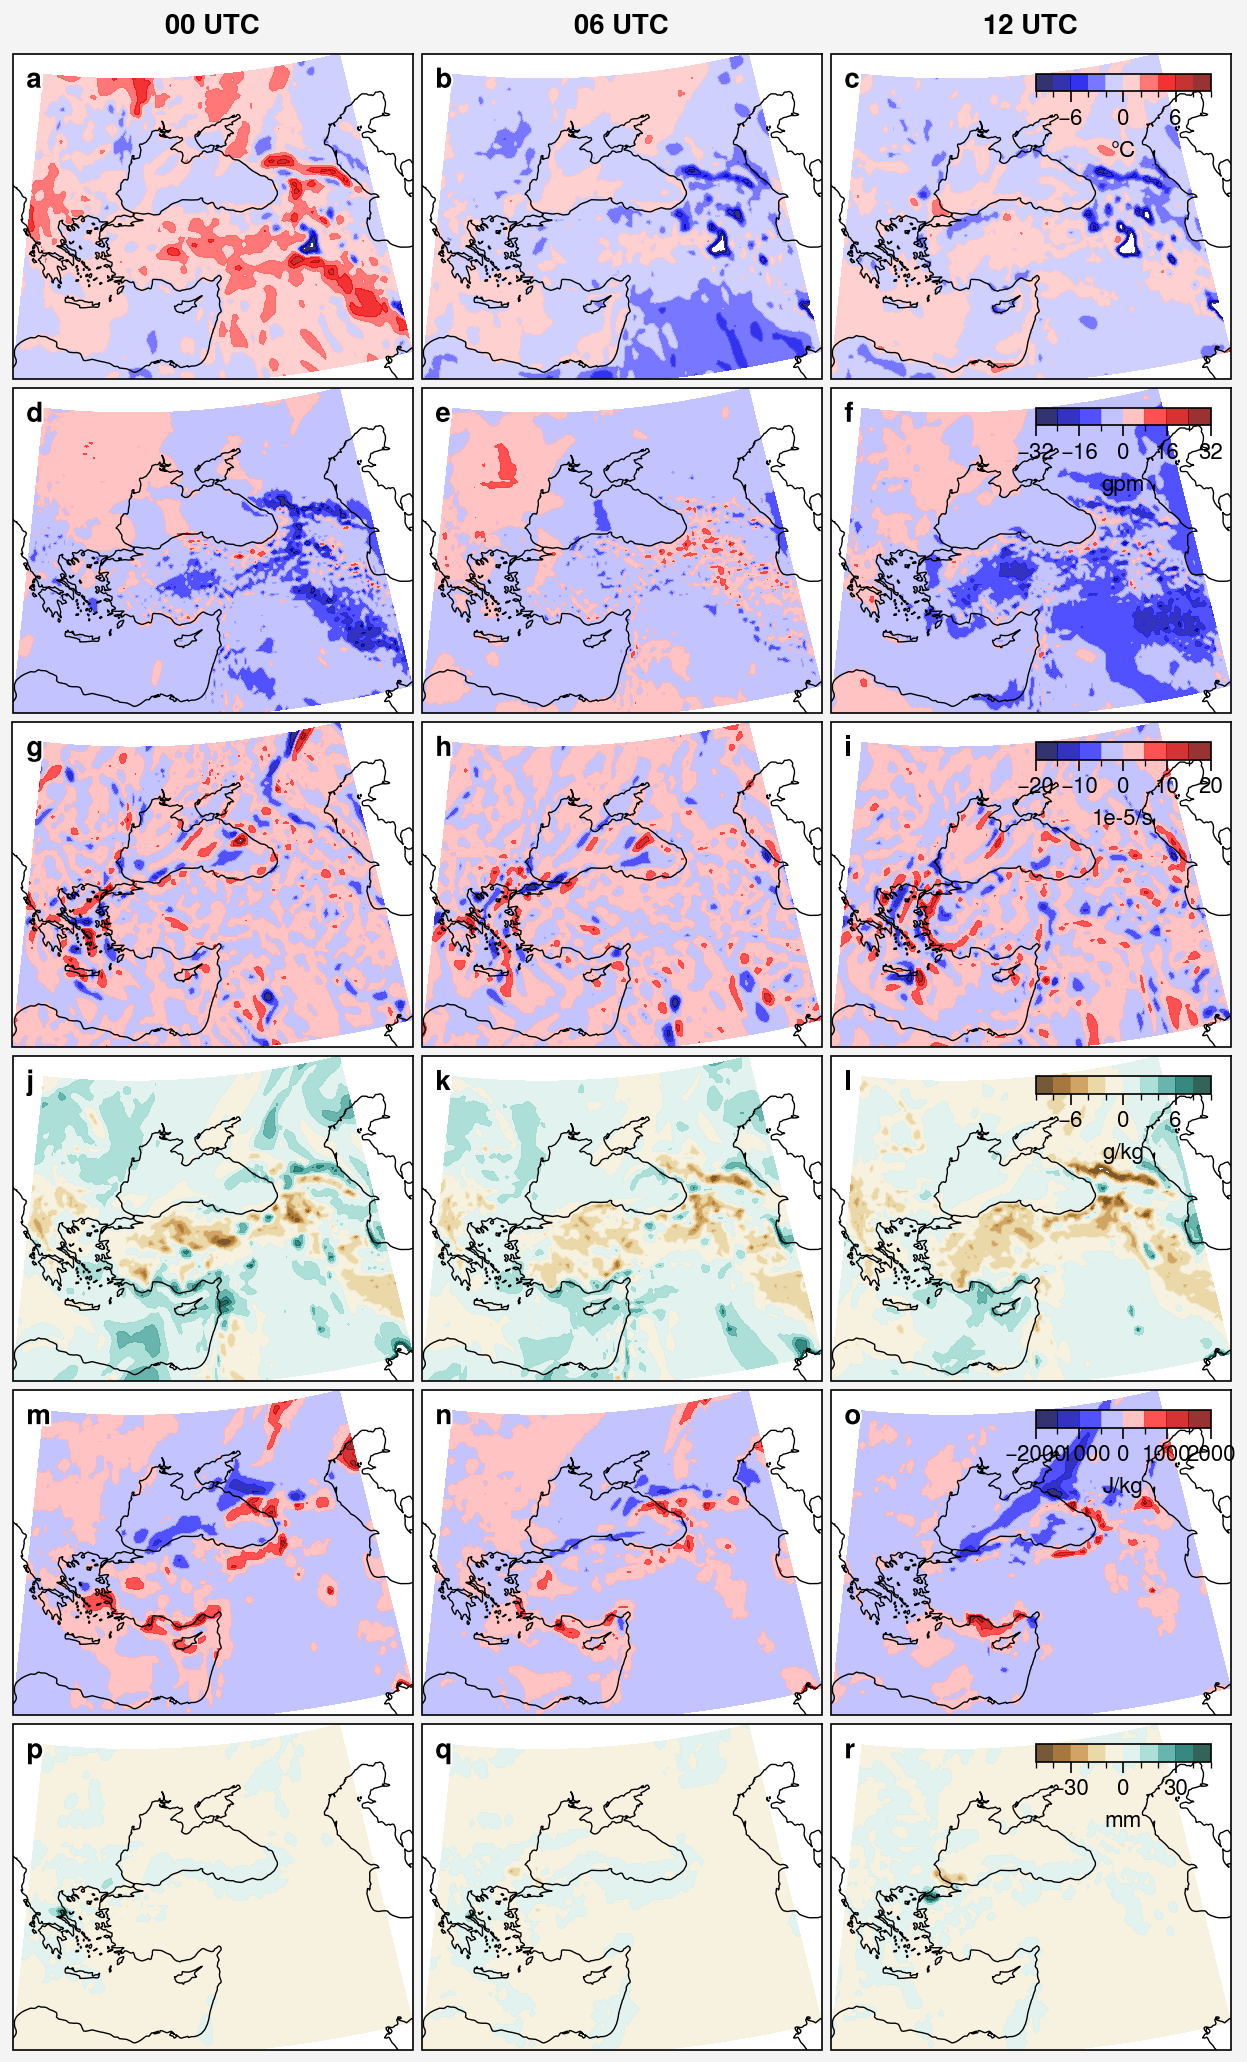

In [72]:
# Create Figure -------------------------
fig, axs = proplot.subplots(fig_array, 
                            aspect=4,
                            axwidth=2,
                            proj=lcc,
                            hratios=tuple(np.ones(len(fig_array), dtype=int)),
                            includepanels=True,
                            hspace=0.36,
                            wspace=0.36,
                            sharey=0)

# format whole figure
axs.format(abcloc='ul',
           abc=True,)

# istanbul limits
axs.format(lonlim=(20, 50),
           latlim=(30, 50),
           labels=False, 
           longrid=False, 
           latgrid = False)

axs.format(collabels=['00 UTC', '06 UTC', '12 UTC'],
           )

#proplot.rc['leftlabel.rotation'] = 'vertical'
proplot.rc.update({'leftlabel.rotation':'vertical'})

# add shapefiles
axs.add_feature(cartopy.feature.LAND.with_scale('50m'),
               zorder=1, linewidths=0.5,
               edgecolor='black', facecolor='none') 

dt_border = urban_luse_border

# diff temperature
vmin_t, vmax_t = -10, 10
vmin_g, vmax_g = -36, 36
vmin_vo, vmax_vo = -24, 24
vmin_spe, vmax_spe = -10, 10
vmin_cape, vmax_cape = -2400, 2400
vmin_tp, vmax_tp = -50, 50

for i in range(3):
    dt_era5 = (era5['t'].isel(time=i).sel(level=level))
    dt_gfs = (gdas['TMP_L100'].isel(time=i).sel(level0=level))
    
    mesh_temp = axs[i].contourf(gdas['lon'], 
                                gdas['lat'],
                                dt_era5.values-dt_gfs.values, 
                                cmap = cmap_diff,
                                vmin = vmin_t,
                                vmax = vmax_t,
                                zorder = 0.2,
                                alpha=0.8)
    
# diff geo height
for i in range(3):
    dt_era5 = (era5['z'].isel(time=i).sel(level=level))
    dt_gfs = (gdas['HGT_L100'].isel(time=i).sel(level0=level))
    mesh_height = axs[i+3].contourf(gdas['lon'], 
                                gdas['lat'],
                                dt_era5.values-dt_gfs.values, 
                                cmap = cmap_diff,
                                vmin = vmin_g,
                                vmax = vmax_g,
                                zorder = 0.2,
                                alpha=0.8)
    
# diff abs vort
for i in range(3):
    dt_era5 = (era5['abs_vo'].isel(time=i).sel(level=level))
    dt_gfs = (gdas['ABS_V_L100'].isel(time=i).sel(level0=level))
    mesh_vort = axs[i+6].contourf(era5['longitude'], 
                                era5['latitude'],
                                dt_era5.values-dt_gfs.values, 
                                cmap = cmap_diff,
                                vmin = vmin_vo,
                                vmax = vmax_vo,
                                zorder = 0.2,
                                alpha=0.8)
    
# diff spe hum
for i in range(3):
    dt_era5 = (era5['q'].isel(time=i).sel(level=level))
    dt_gfs = (gdas['q'].isel(time=i).sel(level0=level))
    mesh_mix = axs[i+9].contourf(era5['longitude'], 
                                era5['latitude'],
                                dt_era5.values-dt_gfs.values, 
                                cmap = 'BrBg',
                                vmin = vmin_spe,
                                vmax = vmax_spe,
                                zorder = 0.2,
                                alpha=0.8)
    
# diff cape
for i in range(3):
    dt_era5 = (era5['cape'].isel(time=i))
    dt_gfs = (gdas['CAPE_Y108'].isel(time=i))
    mesh_cape = axs[i+12].contourf(era5['longitude'], 
                                era5['latitude'],
                                dt_era5.values-dt_gfs.values, 
                                cmap = cmap_diff,
                                vmin = vmin_cape,
                                vmax = vmax_cape,
                                zorder = 0.2,
                                alpha=0.8)
    
# diff tp
for i in range(3):
    dt_era5 = (era5_prec['tp'].isel(time=i))
    dt_gfs = (gdas_prec['A_PCP_L1_Accum_1'].isel(time=i))
    mesh_tp = axs[i+15].contourf(era5['longitude'], 
                                era5['latitude'],
                                dt_era5.values-dt_gfs.values, 
                                cmap = 'BrBg',
                                vmin = vmin_tp,
                                vmax = vmax_tp,
                                zorder = 0.2,
                                alpha=0.8)
    
# colorbars
axs[2].colorbar(mesh_temp,
                 label='°C',
                 loc='ur', length=7,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.7,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=False,
                 pad = 0.8
                )

axs[5].colorbar(mesh_height,
                 label='gpm',
                 loc='ur', length=7,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.7,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=False,
                 pad = 0.8
                )

axs[8].colorbar(mesh_vort,
                 label='1e-5/s',
                 loc='ur', length=7,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.7,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=False,
                 pad = 0.8
                )

axs[11].colorbar(mesh_mix,
                 label='g/kg',
                 loc='ur', length=7,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.7,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=False,
                 pad = 0.8
                )
                                        
axs[14].colorbar(mesh_cape,
                 label='J/kg',
                 loc='ur', length=7,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.7,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=False,
                 pad = 0.8
                )

axs[17].colorbar(mesh_tp,
                 label='mm',
                 loc='ur', length=7,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.7,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=False,
                 pad = 0.8
                )

#save figure
plt.savefig(fr'pictures/combined_boundary_data_diff_era5_minus_gdas_{level}.jpeg',
            bbox_inches='tight', optimize=True,
            progressive=True, dpi=1000)